In [40]:
import json, os
from collections import defaultdict
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches, patheffects
import numpy as np
import seaborn as sns
import pandas as pd
from skimage.measure import block_reduce
import urllib.request
import imageio
from tqdm import tqdm_notebook as tqdm
import pickle
from skimage.transform import resize
import warnings
warnings.filterwarnings("ignore")

## Cloud dataset - basic setup

In [8]:
IMG_PATH = '/local/S.Rasp/MPI_Aqua/raw/'
SAVE_PATH = '/local/S.Rasp/tmp/'
MASK_PATH = '/local/S.Rasp/MPI_Aqua/masks/raw/'

In [5]:
with open('labelbox_annotations/labelbox_0821.json', 'r') as f:
    data_new = json.load(f)

In [6]:
def save(fn, o):
    with open(SAVE_PATH + fn, 'wb') as f:
        pickle.dump(o, f)
def load(fn):
    with open(SAVE_PATH + fn, 'rb') as f:
        o = pickle.load(f)
    return o

In [51]:
fns = load('fns.pkl'); trn_fns = load('trn_fns.pkl'); val_fns = load('val_fns.pkl')
val_idxs = load('val_idxs.pkl'); trn_idxs = load('trn_idxs.pkl'); cats = load('cats.pkl')

In [12]:
sz = np.array(Image.open(IMG_PATH+fns[0])).shape[:-1]; sz

(1144, 1140)

In [13]:
labels = defaultdict(list)
for d in data_new:
    cats = d['Label']
    l = d['Created By']
    fn = d['External ID']
    if 'No fit' in cats.keys():
        labels[fn] = []
    else:
        for i, c in enumerate(list(cats.keys())):
            xs = [cats[c][0]['geometry'][i]['x'] for i in range(4)]
            ys = [cats[c][0]['geometry'][i]['y'] for i in range(4)]
#             bl_x = d['Label'][c][0]['geometry'][1]['x']
#             bl_y = d['Label'][c][0]['geometry'][1]['y']
#             tr_x = d['Label'][c][0]['geometry'][3]['x']
#             tr_y = d['Label'][c][0]['geometry'][3]['y']
            bl_x = np.min(xs); bl_y = np.min(ys)
            tr_x = np.max(xs); tr_y = np.max(ys)
            msk_fn = MASK_PATH + fn[:-4] + f'_m{i}.png'
            if not os.path.exists(msk_fn):
                print('Downloading' + msk_fn)
                urllib.request.urlretrieve(d['Masks'][c], msk_fn)
            labels[fn].append([c, (bl_x, bl_y, tr_x, tr_y), l, msk_fn])

In [18]:
def bb_hw(a): return np.array([a[0],a[1],a[2]-a[0],a[3]-a[1]])

In [119]:
def show_img(fn, ax=None):
    if ax is None: fig, ax = plt.subplots(figsize=(8,8))
    img = Image.open(IMG_PATH + fn)
    ax.imshow(np.flipud(img), origin='lower')
    for l in labels[fn]:
        bb = bb_hw(l[1])
        patch = ax.add_patch(
            patches.Rectangle(bb[:2], *bb[-2:], fill=False, edgecolor='red', lw=2))
#         print(l[1], bb)
        text = ax.text(*bb[:2], l[0] + ' ' + l[2], horizontalalignment='left',
                verticalalignment='bottom', color='red', fontsize=15, weight='bold')

In [16]:
cats

['No fit', 'Shallow', 'Cold pool', 'Flower', 'Fishbone']

In [17]:
cat2id = {c: i for i, c in enumerate(cats)}

## Prepare the masks

In [20]:
cat2id

{'No fit': 0, 'Shallow': 1, 'Cold pool': 2, 'Flower': 3, 'Fishbone': 4}

In [21]:
for fn, l in tqdm(labels.items()):
    
    ms = []
    for ll in l:
        bb = ll[1]
        m = np.zeros(sz)
        m[bb[1]:bb[3],bb[0]:bb[2]] = cat2id[ll[0]]
        ms.append(m)
    if len(l) > 1:
        ms_bin = [np.greater(m, 0) for m in ms]
        ms = np.array(ms)
        ms_bin = np.array(ms_bin)
        overlap = np.equal(np.mean(ms, 0), ms[0])
        tot_msk = np.mean(ms, 0)
        too_many = (overlap == 0) & (np.sum(ms_bin, 0) > 1)
        one_cat  = (overlap == 0) & (np.sum(ms_bin, 0) == 1)
        tot_msk[too_many] = 0; tot_msk[one_cat] = np.max(ms, 0)[one_cat]
    elif len(l) == 1:
        tot_msk = m
    else:
        tot_msk = np.zeros(sz)
    tot_msk = np.flipud(tot_msk.astype('uint8'))
    imageio.imsave(MASK_PATH + fn, tot_msk)

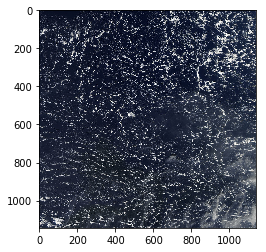

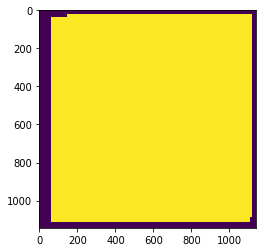

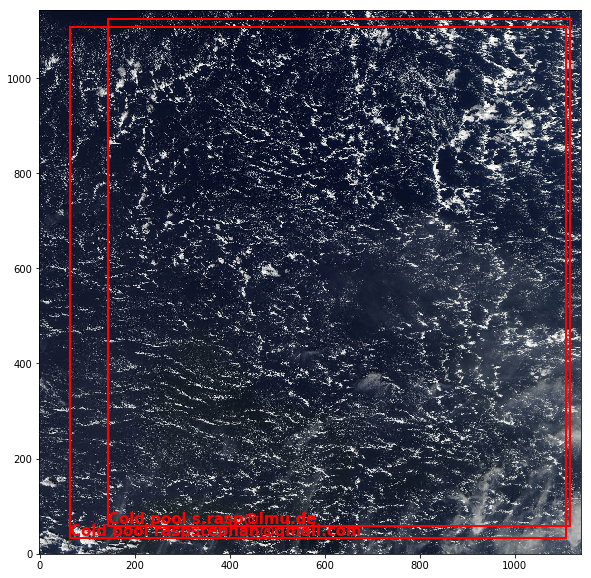

In [22]:
fn = fns[5]
plt.imshow(Image.open(IMG_PATH + fn)); plt.show()
plt.imshow(np.array(Image.open(MASK_PATH + fn))); plt.show()
show_img(fns[5])

### convert

In [23]:
cat2id

{'No fit': 0, 'Shallow': 1, 'Cold pool': 2, 'Flower': 3, 'Fishbone': 4}

In [24]:
tot_masks = []
for fn in tqdm(fns):
    m = np.array(Image.open(MASK_PATH + fn))
    m2 = np.zeros((*sz, 5), dtype='uint8')
    for i in range(5):
        m2[m==i, i] = 1
    tot_masks.append(m2)

In [25]:
tot_masks = np.array(tot_masks); tot_masks.shape

(903, 1144, 1140, 5)

In [29]:
tot_masks[:10].max()

1

In [31]:
np.save(SAVE_PATH + 'tot_masks.npy', tot_masks)

In [32]:
imgs = [np.array(Image.open(IMG_PATH + fn)) for fn in fns]

In [33]:
imgs = np.array(imgs); imgs.shape

(903, 1144, 1140, 3)

In [35]:
imgs[:10].max()

255

In [36]:
np.save(SAVE_PATH + 'imgs.npy', imgs)

In [41]:
imgs_re = [resize(imgs[i], (256, 256)) for i in range(len(imgs))]

In [42]:
imgs_re = np.array(imgs_re); imgs_re.shape

(903, 256, 256, 3)

In [44]:
np.save(SAVE_PATH + 'imgs_re.npy', imgs_re)

In [45]:
tot_masks_re = [resize(tot_masks[i]*255, (256, 256)) for i in range(len(imgs))]
tot_masks_re = np.array(tot_masks_re); tot_masks_re.shape

(903, 256, 256, 5)

In [47]:
np.save(SAVE_PATH + 'tot_masks_re.npy', tot_masks_re)

### Get balanced datasets

In [81]:
cls_weights = (tot_masks_re.sum((1, 2)) > 0).mean(0)
cls_weights = 1 / cls_weights
cls_weights

array([1.        , 2.84858044, 5.40718563, 6.06040268, 8.68269231])

In [82]:
cls_weights = {i: c for i, c in enumerate(cls_weights)}; cls_weights

{0: 1.0,
 1: 2.8485804416403786,
 2: 5.407185628742515,
 3: 6.060402684563758,
 4: 8.682692307692308}

In [89]:
(tot_masks_re.sum((1, 2)) > 0).shape

(903, 5)

In [92]:
trn_imgs = imgs_re[trn_idxs]
trn_mask = tot_masks_re[trn_idxs]
trn_mask.shape

(768, 256, 256, 5)

In [101]:
c = 'Shallow'

In [102]:
has_c = trn_mask.sum((1, 2))[:, cat2id[c]] > 0

In [103]:
a_imgs = np.concatenate((trn_imgs[has_c], trn_imgs[~has_c][:int(len(trn_imgs)/cls_weights[cat2id[c]])]))

In [104]:
a_imgs.shape

(538, 256, 256, 3)

## Unet

In [83]:
import tensorflow as tf
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [84]:
seed = 1
bs=16

In [155]:
def _tv_gen(s, c, balance=False):
    if s == 'training':
        gen_args = dict(rotation_range=15.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.1,
                         horizontal_flip=True,
                         vertical_flip=True,
                         )
        idxs = trn_idxs
    else:
        gen_args = dict()
        idxs= val_idxs
    
    # Get a balanced dataset
    imgs = imgs_re[idxs]
    masks = tot_masks_re[idxs]
    if balance: 
        has_c = masks.sum((1, 2))[:, cat2id[c]] > 0
        imgs = np.concatenate((imgs[has_c], imgs[~has_c][:int(len(imgs)/cls_weights[cat2id[c]])]))
        masks = np.concatenate((masks[has_c], masks[~has_c][:int(len(masks)/cls_weights[cat2id[c]])]))
    
    image_datagen = ImageDataGenerator(**gen_args)
    mask_datagen = ImageDataGenerator(**gen_args)
    gen = zip(
        image_datagen.flow(
            imgs,
            batch_size=bs,
            seed=seed,
        ),
        mask_datagen.flow(
            masks[:, :, :, cat2id[c]][:, :, :, None],
            batch_size=bs,
            seed=seed,
        )
    )
    return gen

In [159]:
def create_gens(c, balance=False):
    train_gen = _tv_gen('training', c, balance)
    valid_gen = _tv_gen('validation', c)
    return train_gen, valid_gen

In [157]:
#https://www.kaggle.com/kmader/data-preprocessing-and-unet-segmentation-gpu
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [158]:
def build_model(lr=1e-4, loss = 'binary_crossentropy'): 
    # Build U-Net model
    inputs = Input((256, 256, 3))

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(lr), loss=loss, metrics=['accuracy'])
    #model.summary()
    return model

In [160]:
def train_model(c, epochs=15, balance=False):
    train_gen, valid_gen = create_gens(c, balance)
    m = build_model(loss=dice_coef_loss)
    m.fit_generator(
        train_gen,
        steps_per_epoch=50,
        epochs=epochs,
        validation_data=valid_gen,
        validation_steps=5
    )
    return m

In [161]:
for c in cats[1:]:
    print(c)
    m = train_model(c)
    m.save(f'/local/S.Rasp/tmp/{c}_dice_no_balance.h5')

Shallow
Epoch 1/15
50/50 [==============================] - 14s 287ms/step - loss: -0.1894 - acc: 0.7657 - val_loss: -0.2209 - val_acc: 0.6066
Epoch 2/15
50/50 [==============================] - 12s 241ms/step - loss: -0.1901 - acc: 0.5256 - val_loss: -0.1781 - val_acc: 0.5062
Epoch 3/15
50/50 [==============================] - 12s 245ms/step - loss: -0.1958 - acc: 0.5749 - val_loss: -0.2246 - val_acc: 0.5474
Epoch 4/15
50/50 [==============================] - 12s 247ms/step - loss: -0.2176 - acc: 0.5734 - val_loss: -0.2180 - val_acc: 0.6206
Epoch 5/15
50/50 [==============================] - 13s 253ms/step - loss: -0.2591 - acc: 0.6317 - val_loss: -0.3355 - val_acc: 0.7010
Epoch 6/15
50/50 [==============================] - 13s 250ms/step - loss: -0.3615 - acc: 0.7428 - val_loss: -0.2588 - val_acc: 0.6072
Epoch 7/15
50/50 [==============================] - 12s 249ms/step - loss: -0.4185 - acc: 0.8149 - val_loss: -0.3491 - val_acc: 0.6576
Epoch 8/15
50/50 [=============================

In [165]:
models = {c: keras.models.load_model(f'/local/S.Rasp/tmp/{c}_dice.h5', 
                                     custom_objects={'dice_coef_loss': dice_coef_loss}) for c in cats[1:]}
# models_nb = {c: keras.models.load_model(f'/local/S.Rasp/tmp/{c}_dice_no_balance.h5', 
#                                      custom_objects={'dice_coef_loss': dice_coef_loss}) for c in cats[1:]}

In [166]:
def check_preds(i, ms = [models]):
    show_img(fns[i]); plt.show()
    X = imgs_re[i]; Y = tot_masks_re[i]
    for m in ms:
        preds = [m[c].predict(X[None])[0, :, :, 0] for c in cats[1:]]
        fig, axs = plt.subplots(1, 4, figsize=(15, 5))
        for i, ax in enumerate(axs.flat):
            ax.set_title(cats[i+1])
            tmp = ax.imshow(preds[i], vmin=0, vmax=1)
        fig.colorbar(tmp, ax=axs, orientation='horizontal', shrink=0.5)
        plt.show()

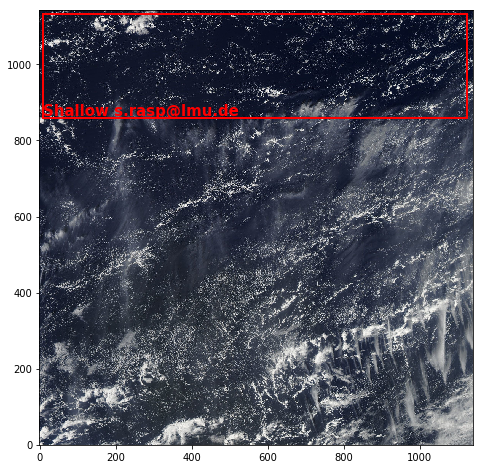

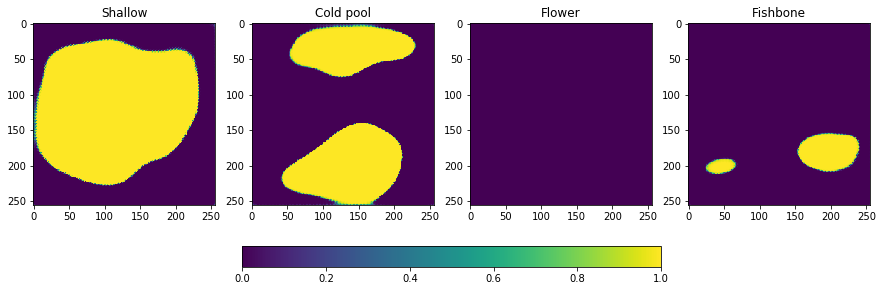

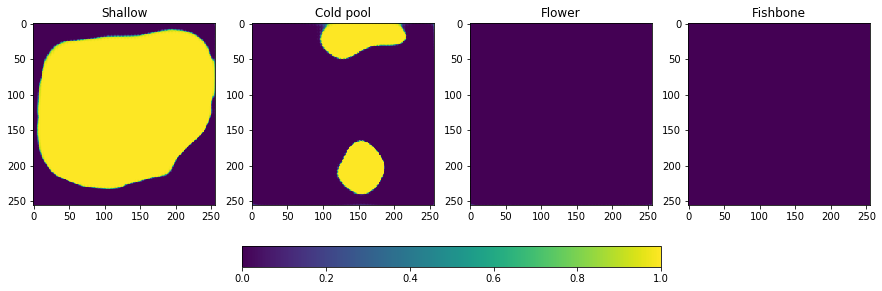

In [169]:
check_preds(val_idxs[1])

In [155]:
X, Y = next(train_generator)

In [156]:
preds = model.predict(X)

In [157]:
X.shape, Y.shape, preds.shape

((16, 256, 256, 3), (16, 256, 256, 1), (16, 256, 256, 1))

In [158]:
Y[0].shape

(256, 256, 1)

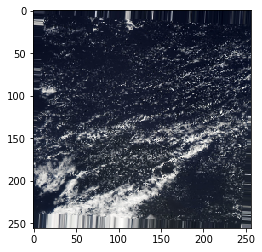

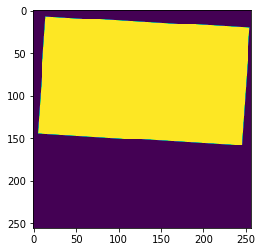

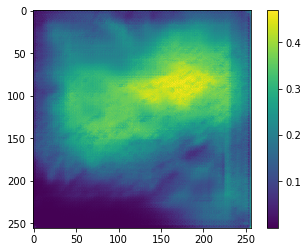

In [172]:
i=11
plt.imshow(X[i]); plt.show()
plt.imshow(Y[i, :, :, 0]); plt.show()
plt.imshow(preds[i, :, :, 0]); plt.colorbar(); plt.show()

## Multi-class Unet

https://github.com/keras-team/keras/issues/9395

In [23]:
from skimage.transform import resize
import warnings
warnings.filterwarnings("ignore")

In [121]:
imgs_re = [resize(imgs[i], (256, 256)) for i in range(len(imgs))]

In [122]:
imgs_re = np.array(imgs_re); imgs_re.shape

(903, 256, 256, 3)

In [144]:
tot_masks

array([[[[1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         ...,
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0]],

        [[1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         ...,
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0]],

        [[1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         ...,
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0]],

        ...,

        [[1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         ...,
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0]],

        [[1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         ...,
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0]],

        [[1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         ...,
         [1, 0, 0, 0, 0],
        

In [150]:
tot_masks_re = [resize(tot_masks[i]*255, (256, 256)) for i in range(len(imgs))]
tot_masks_re = np.array(tot_masks_re); tot_masks_re.shape

(903, 256, 256, 5)

In [151]:
tot_masks_re

array([[[[1.      , 0.      , 0.      , 0.      , 0.      ],
         [1.      , 0.      , 0.      , 0.      , 0.      ],
         [1.      , 0.      , 0.      , 0.      , 0.      ],
         ...,
         [1.      , 0.      , 0.      , 0.      , 0.      ],
         [1.      , 0.      , 0.      , 0.      , 0.      ],
         [1.      , 0.      , 0.      , 0.      , 0.      ]],

        [[1.      , 0.      , 0.      , 0.      , 0.      ],
         [1.      , 0.      , 0.      , 0.      , 0.      ],
         [1.      , 0.      , 0.      , 0.      , 0.      ],
         ...,
         [1.      , 0.      , 0.      , 0.      , 0.      ],
         [1.      , 0.      , 0.      , 0.      , 0.      ],
         [1.      , 0.      , 0.      , 0.      , 0.      ]],

        [[1.      , 0.      , 0.      , 0.      , 0.      ],
         [1.      , 0.      , 0.      , 0.      , 0.      ],
         [1.      , 0.      , 0.      , 0.      , 0.      ],
         ...,
         [1.      , 0.      , 0.      ,

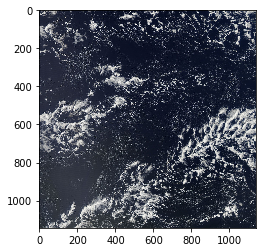

In [124]:
plt.imshow(imgs[7])

In [125]:
np.mean(tot_masks[1, :, :, 0])

0.7187078272604588

In [70]:
tot_masks_re

array([[[[0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157]],

        [[0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157]],

        [[0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157,

In [147]:
1/0.00392157

254.99991075003123

In [126]:
np.mean(tot_masks, (0, 1, 2))

array([0.68100023, 0.08898475, 0.0364641 , 0.12390942, 0.0696415 ])

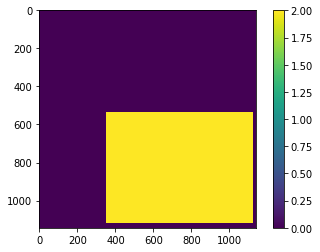

In [127]:
plt.imshow(np.array(Image.open(MASK_PATH + fns[7]))); plt.colorbar()

In [98]:
cats

['No fit', 'Flower', 'Fishbone', 'Shallow', 'Cold pool']

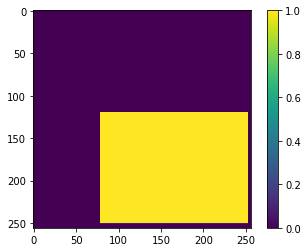

In [152]:
plt.imshow(tot_masks_re[7, :, :, 2]); plt.colorbar()

In [153]:
data_gen_args = dict(rotation_range=15.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True,
                     validation_split=0.1
                     )
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args, )

In [154]:
seed = 1
bs = 16

In [155]:
train_generator = zip(
    image_datagen.flow(
        imgs_re,
        batch_size=bs,
        seed=seed,
        subset='training'
    ),
    mask_datagen.flow(
        tot_masks_re,
        batch_size=bs,
        seed=seed,
        subset='training',
    )
)

In [156]:
valid_generator = zip(
    image_datagen.flow(
        imgs_re,
        batch_size=bs,
        seed=seed,
        subset='validation'
    ),
    mask_datagen.flow(
        tot_masks_re,
        batch_size=bs,
        seed=seed,
        subset='validation',
    )
)

In [157]:
# Build U-Net model
inputs = Input((256, 256, 3))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(5, (1, 1), activation='softmax') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 256, 256, 8)  224         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 256, 256, 8)  584         conv2d_77[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 128, 128, 8)  0           conv2d_78[0][0]                  
__________________________________________________________________________________________________
conv2d_79 

In [169]:
model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=5
)

Epoch 1/10
50/50 [==============================] - 27s 544ms/step - loss: 0.9870 - acc: 0.6908 - val_loss: 0.9619 - val_acc: 0.7202
Epoch 2/10
50/50 [==============================] - 24s 479ms/step - loss: 0.9575 - acc: 0.7031 - val_loss: 0.9171 - val_acc: 0.7304
Epoch 3/10
50/50 [==============================] - 24s 488ms/step - loss: 0.9693 - acc: 0.6958 - val_loss: 0.9037 - val_acc: 0.7214
Epoch 4/10
50/50 [==============================] - 25s 492ms/step - loss: 0.9585 - acc: 0.6976 - val_loss: 0.9258 - val_acc: 0.7153
Epoch 5/10
50/50 [==============================] - 25s 493ms/step - loss: 0.9650 - acc: 0.6937 - val_loss: 0.9292 - val_acc: 0.7110
Epoch 6/10
50/50 [==============================] - 26s 521ms/step - loss: 0.9514 - acc: 0.6968 - val_loss: 0.8919 - val_acc: 0.7280
Epoch 7/10
50/50 [==============================] - 26s 510ms/step - loss: 0.9492 - acc: 0.7009 - val_loss: 0.9187 - val_acc: 0.7241
Epoch 8/10
50/50 [==============================] - 26s 520ms/step - 

In [170]:
X, Y = next(train_generator)

In [171]:
X

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.06717337, 0.08649661, 0.16839676],
         [0.04793158, 0.07692137, 0.15156502],
         [0.04885205, 0.07348982, 0.15768139]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.06745662, 0.08693762, 0.16848554],
         [0.04820507, 0.07703545, 0.1518159 ],
         [0.0487999 , 0.07352984, 0.1575482 ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.06773986, 0.08737862, 0.16857433],
         [0.04847855, 0.07714952, 0.15206681],
         [0.04874776, 0.07356986, 0.15741503]],

        ...,

        [[0.753462  , 0.76130515, 0.7416973 ],
         [0.753462  , 0.76130515, 0.7416973 ]

In [172]:
preds = model.predict(X)

In [173]:
X.shape, Y.shape, preds.shape

((13, 256, 256, 3), (13, 256, 256, 5), (13, 256, 256, 5))

In [174]:
Y, preds

(array([[[[1.      , 0.      , 0.      , 0.      , 0.      ],
          [1.      , 0.      , 0.      , 0.      , 0.      ],
          [1.      , 0.      , 0.      , 0.      , 0.      ],
          ...,
          [1.      , 0.      , 0.      , 0.      , 0.      ],
          [1.      , 0.      , 0.      , 0.      , 0.      ],
          [1.      , 0.      , 0.      , 0.      , 0.      ]],
 
         [[1.      , 0.      , 0.      , 0.      , 0.      ],
          [1.      , 0.      , 0.      , 0.      , 0.      ],
          [1.      , 0.      , 0.      , 0.      , 0.      ],
          ...,
          [1.      , 0.      , 0.      , 0.      , 0.      ],
          [1.      , 0.      , 0.      , 0.      , 0.      ],
          [1.      , 0.      , 0.      , 0.      , 0.      ]],
 
         [[1.      , 0.      , 0.      , 0.      , 0.      ],
          [1.      , 0.      , 0.      , 0.      , 0.      ],
          [1.      , 0.      , 0.      , 0.      , 0.      ],
          ...,
          [1.      

In [175]:
def show_preds(X, Y, idx):
    plt.imshow(X[idx]); plt.show()
    fig, axs = plt.subplots(2, 3, figsize=(10, 10))
    axs=axs.flat
    for i in range(len(cats)):
        axs[i].set_title(cats[i])
        axs[i].imshow(Y[idx, :, :, i], vmin=0, vmax=1)
    plt.show()
    fig, axs = plt.subplots(2, 3, figsize=(10, 10))
    axs=axs.flat
    for i in range(len(cats)):
        axs[i].set_title(cats[i])
        axs[i].imshow(preds[idx, :, :, i], vmin=0, vmax=1)
    plt.show()

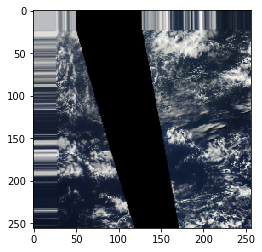

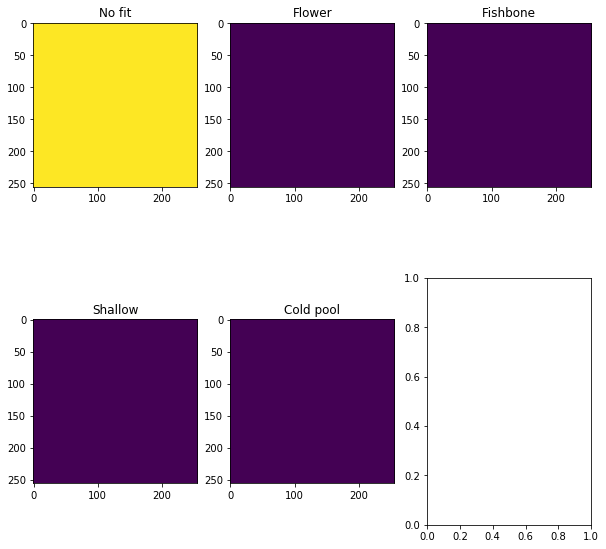

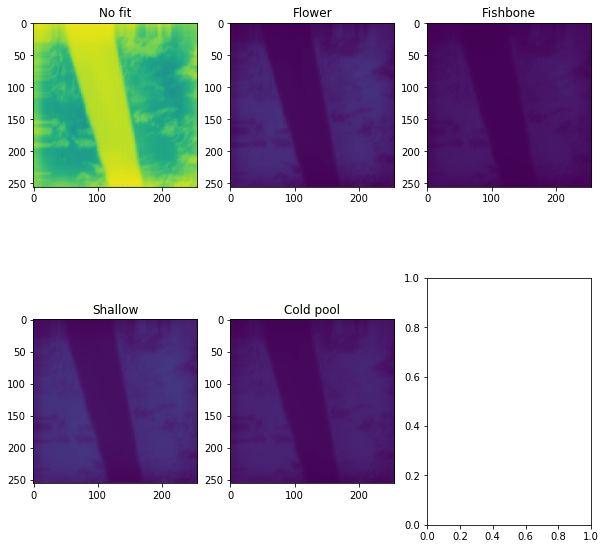

In [179]:
show_preds(X, Y, 4)

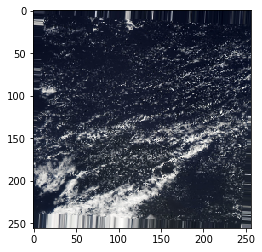

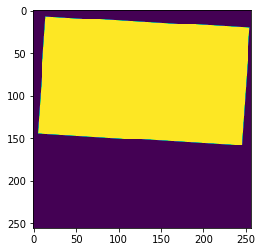

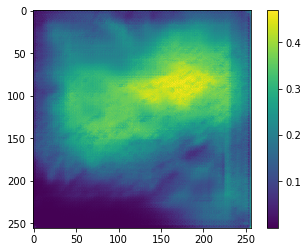

In [172]:
i=11
plt.imshow(X[i]); plt.show()
plt.imshow(Y[i, :, :, 0]); plt.show()
plt.imshow(preds[i, :, :, 0]); plt.colorbar(); plt.show()